### Final Project Objective
Build a production-ready ML system that:

Uses realistic database-driven input

Predicts churn likelihood

Identifies key churn drivers (SHAP, feature importance)

Provides a Streamlit interface for business users to get churn risk scores

Documents your work for team/management presentation and GitHub demo

In [3]:
import pandas as pd
import psycopg2

conn = psycopg2.connect(
    dbname = "churn_db",
    user = "postgres",
    password = "skm1h@swgrss",
    host = "localhost",
    port = "5432"
)

data = pd.read_sql("select * from customers;", conn)

C:\Users\Hitesh Bhatnagar\AppData\Local\Temp\ipykernel_34188\2944337137.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql("select * from customers;", conn)


##### Convert columns to proper types

In [4]:
data['total_charges'] = pd.to_numeric(data['total_charges'], errors = 'coerce')
data['monthly_charges'] = pd.to_numeric(data['monthly_charges'], errors = 'coerce')
data['tenure'] = pd.to_numeric(data['tenure'], errors = 'coerce')

data.dropna(inplace = True)

In [5]:
data['avg_monthly_spend'] = data['total_charges']/(data['tenure'] + 1)  ##  avoid dividing by 0

##  FEATURE will be is the customer long term ?
data['long_term'] = data['tenure'].apply(lambda x: 1 if x > 12 else 0)

In [6]:
data.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,avg_monthly_spend,long_term
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,14.925000,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.50,No,53.985714,1
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,36.050000,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,40.016304,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,50.550000,0


##### Convert categorical --> Binary where needed

In [7]:
binary_map = {'Yes': 1, 'No' : 0}
binary_cols = ['partner', 'dependents', 'phone_service', 'paperless_billing', 'churn']

for col in binary_cols:
    data[col] = data[col].map(binary_map)

In [8]:
data = pd.get_dummies(data, drop_first=True)

In [13]:
data.drop('customer_id', axis=1, inplace=True, errors='ignore')

In [14]:
data.head()

,partner,dependents,tenure,phone_service,paperless_billing,monthly_charges,total_charges,churn,avg_monthly_spend,long_term,...,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_One year,contract_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check
0,1,0,1,0,1,29.85,29.85,0,14.925000,0,...,False,False,False,False,False,False,False,False,True,False
1,0,0,34,1,0,56.95,1889.50,0,53.985714,1,...,False,False,False,False,False,True,False,False,False,True
2,0,0,2,1,1,53.85,108.15,1,36.050000,0,...,False,False,False,False,False,False,False,False,False,True
3,0,0,45,0,0,42.30,1840.75,0,40.016304,1,...,True,False,False,False,False,True,False,False,False,False
4,0,0,2,1,1,70.70,151.65,1,50.550000,0,...,False,False,False,False,False,False,False,False,True,False


In [18]:
bool_cols = data.select_dtypes(include = ['bool']).columns.tolist()
print("Boolean columns remaining: ", bool_cols)

data[bool_cols] = data[bool_cols].astype(int)

Boolean columns remaining:  ['customer_id_0003-MKNFE', 'customer_id_0004-TLHLJ', 'customer_id_0011-IGKFF', 'customer_id_0013-EXCHZ', 'customer_id_0013-MHZWF', 'customer_id_0013-SMEOE', 'customer_id_0014-BMAQU', 'customer_id_0015-UOCOJ', 'customer_id_0016-QLJIS', 'customer_id_0017-DINOC', 'customer_id_0017-IUDMW', 'customer_id_0018-NYROU', 'customer_id_0019-EFAEP', 'customer_id_0019-GFNTW', 'customer_id_0020-INWCK', 'customer_id_0020-JDNXP', 'customer_id_0021-IKXGC', 'customer_id_0022-TCJCI', 'customer_id_0023-HGHWL', 'customer_id_0023-UYUPN', 'customer_id_0023-XUOPT', 'customer_id_0027-KWYKW', 'customer_id_0030-FNXPP', 'customer_id_0031-PVLZI', 'customer_id_0032-PGELS', 'customer_id_0036-IHMOT', 'customer_id_0040-HALCW', 'customer_id_0042-JVWOJ', 'customer_id_0042-RLHYP', 'customer_id_0048-LUMLS', 'customer_id_0048-PIHNL', 'customer_id_0052-DCKON', 'customer_id_0052-YNYOT', 'customer_id_0056-EPFBG', 'customer_id_0057-QBUQH', 'customer_id_0058-EVZWM', 'customer_id_0060-FUALY', 'customer

In [19]:
data.head()

,partner,dependents,tenure,phone_service,paperless_billing,monthly_charges,total_charges,churn,avg_monthly_spend,long_term,...,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_One year,contract_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check
0,1,0,1,0,1,29.85,29.85,0,14.925000,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,34,1,0,56.95,1889.50,0,53.985714,1,...,0,0,0,0,0,1,0,0,0,1
2,0,0,2,1,1,53.85,108.15,1,36.050000,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,45,0,0,42.30,1840.75,0,40.016304,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,2,1,1,70.70,151.65,1,50.550000,0,...,0,0,0,0,0,0,0,0,1,0


In [21]:
assert data.select_dtypes(include = ['object', 'bool']).shape[1] == 0, "Still non-numeric columns present!"

##### Exploratory Data Analysis (EDA)

Text(0.5, 1.0, 'Churn vs monthly charges')

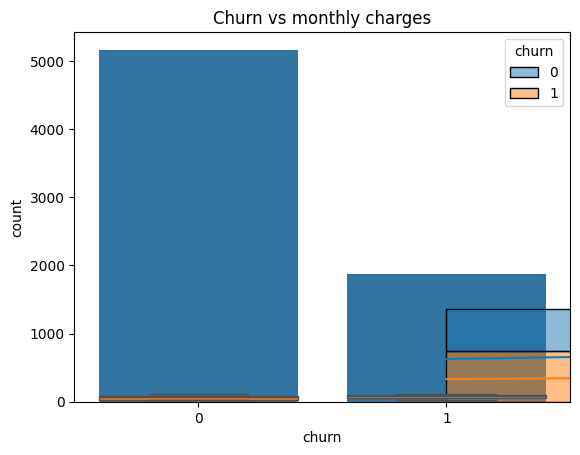

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data = data, x = 'churn')
plt.title("Churn Distribution")

sns.histplot(data = data, x = 'tenure', hue= 'churn', kde = True, multiple = "stack")
plt.title("Churn vs Tenure")

sns.boxplot(data = data, x = 'churn', y = 'monthly_charges')
plt.title("Churn vs monthly charges")

#### 

##### Model training

In [24]:
from sklearn.model_selection import train_test_split

X = data.drop('churn', axis = 1)
y = data['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [26]:
from sklearn.preprocessing import StandardScaler

numeric_cols = X.select_dtypes(include = ['int64','float64']).columns.tolist()
scaler = StandardScaler()

# Fit on training data ONLY
scaler.fit(X_train[numeric_cols])

# Transform both train and test sets
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [30]:
###     Baseline model

from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import numpy as np

###     Huber Regressor

huber_model = HuberRegressor(max_iter=1000)
huber_scores = cross_val_score(huber_model, X_train, y_train, scoring='neg_mean_squared_error', cv = 5, verbose = 1, n_jobs = -1)
huber_rmse_scores = np.sqrt(-huber_scores)

print("     Huber Regressor Baseline  ")
print(f"RMSE scores for each fold: {huber_rmse_scores}")
print(f"Average CV RMSE: {huber_rmse_scores.mean():.4f}")
print(f"Standard deviation of CV RMSE: {huber_rmse_scores.std():.4f}\n")

###     RandomForest Regressor

rf_model = RandomForestRegressor(n_estimators= 20, random_state= 42, n_jobs = -1)
rf_scores = cross_val_score(rf_model, X_train, y_train, scoring = 'neg_mean_squared_error', cv = 5, verbose = 1, n_jobs = -1)
rf_rmse_scores = np.sqrt(-rf_scores)

print("     Random Forest Regressor Baseline")
print(f"RMSE scores for each fold: {rf_rmse_scores}")
print(f"Average CV RMSE: {rf_rmse_scores.mean():.4f}")
print(f"Standard Deviation of CV RMSE: {rf_rmse_scores.std():.4f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 11.7min remaining: 17.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


     Huber Regressor Baseline  
RMSE scores for each fold: [0.4468057  0.47566427 0.48051092 0.45826549 0.45638946]
Average CV RMSE: 0.4635
Standard deviation of CV RMSE: 0.0126



[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.8s remaining:   13.3s


     Random Forest Regressor Baseline
RMSE scores for each fold: [0.38005051 0.39646244 0.39251589 0.39231661 0.3987409 ]
Average CV RMSE: 0.3920
Standard Deviation of CV RMSE: 0.0065


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.5s finished


##### Residual & Error Analysis
Critical Regression tasks.

It helps answer :

    `Where is the model underperforming ?`
    `Are errors consistent or biased ?`

In [32]:
rf_model.fit(X_train, y_train)
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

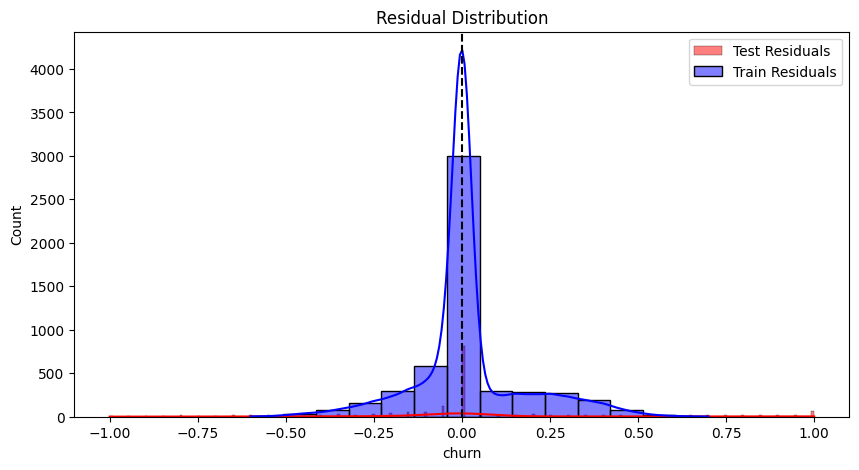

In [ ]:
##  You want a symmetric, centered at 0 distribution (ideally normal). Skew or multimodal means model issues.

plt.figure(figsize=(10,5))
sns.histplot(test_residuals, kde=True, color='red', label="Test Residuals")
sns.histplot(train_residuals, kde=True, color='blue', label="Train Residuals")
plt.axvline(0, color='black', linestyle='--')
plt.title("Residual Distribution")
plt.legend()
plt.show()


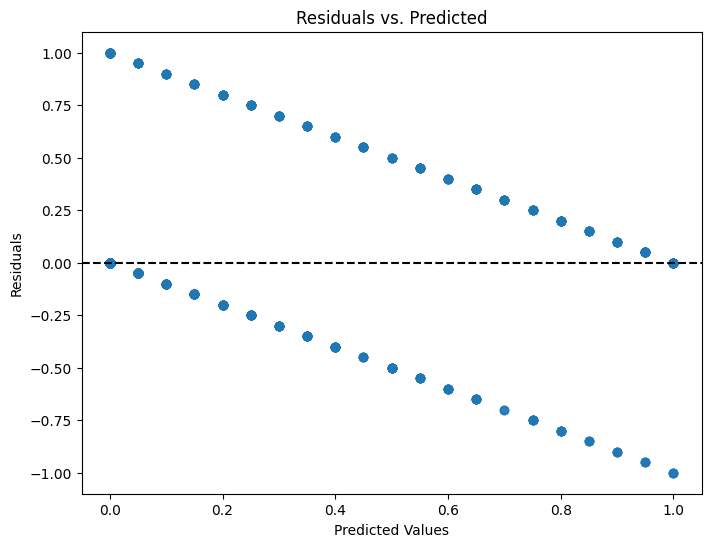

In [ ]:
#  Insight:

# No clear pattern = good

# Funnel shape = heteroscedasticity (errors grow with value)

# Curve shape = model underfitting

plt.figure(figsize=(8,6))
plt.scatter(y_test_pred, test_residuals, alpha=0.4)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted")
plt.show()


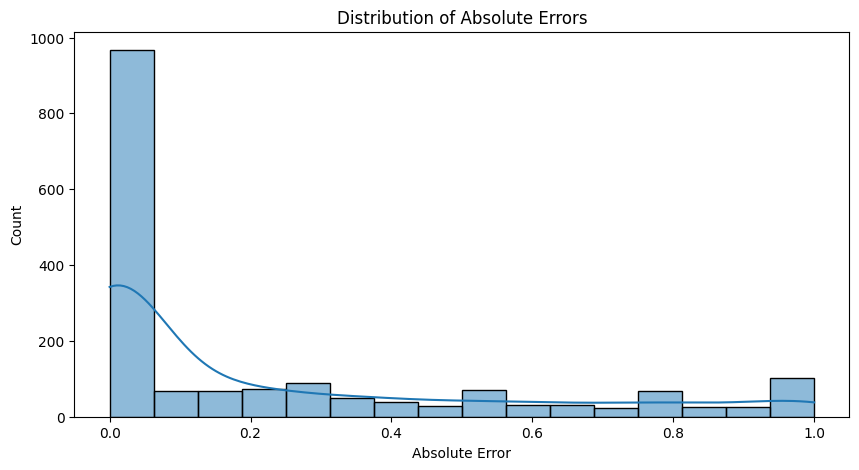

In [35]:
error_magnitude = abs(y_test - y_test_pred)

plt.figure(figsize=(10,5))
sns.histplot(error_magnitude, kde=True)
plt.title("Distribution of Absolute Errors")
plt.xlabel("Absolute Error")
plt.show()


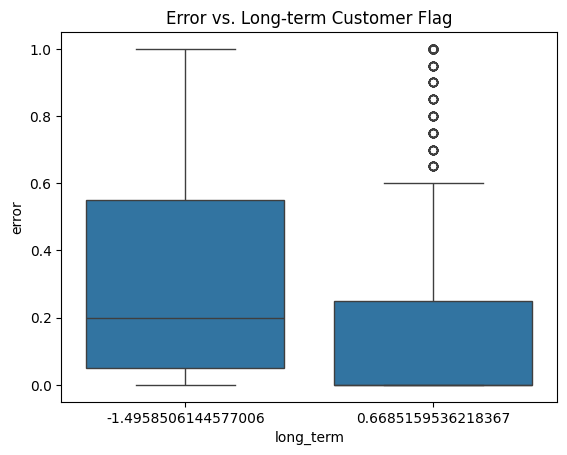

In [39]:
df_test = X_test.copy()
df_test['error'] = abs(y_test - y_test_pred)

# Example with tenure
sns.boxplot(data=df_test, x='long_term', y='error')
plt.title("Error vs. Long-term Customer Flag")
plt.show()


In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")


RMSE: 0.3866
MAE:  0.2261
R²:   0.2340


##### SHAP - SHapley Additive exPlainations

`Understands which features matter most

explain a single prediction (local view)

visulize global impact`

In [41]:
import shap 
shap.initjs()

In [45]:
explainer = shap.TreeExplainer(rf_model) # No check_additivity here
shap_values = explainer.shap_values(X_train, check_additivity=False) # check_additivity goes here!

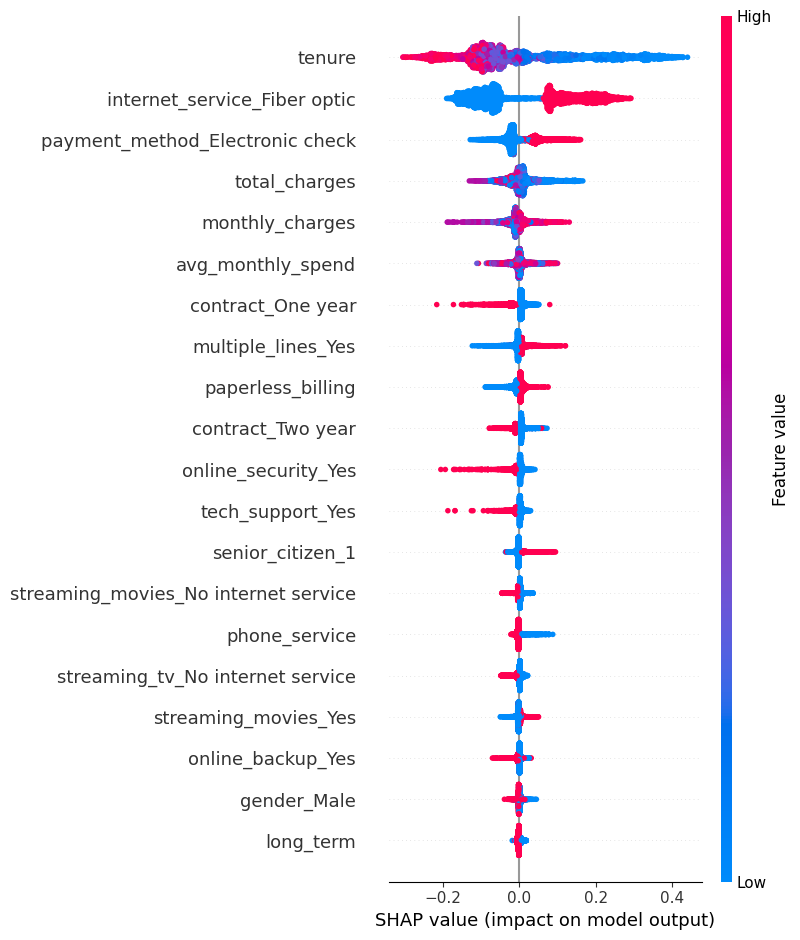

In [46]:
###  Interpretations

# Each dot = 1 sample

# Features are sorted by importance

# Color = feature value (red = high, blue = low)

# Position = SHAP value (impact on prediction)


shap.summary_plot(shap_values, X_train, plot_type = "dot")

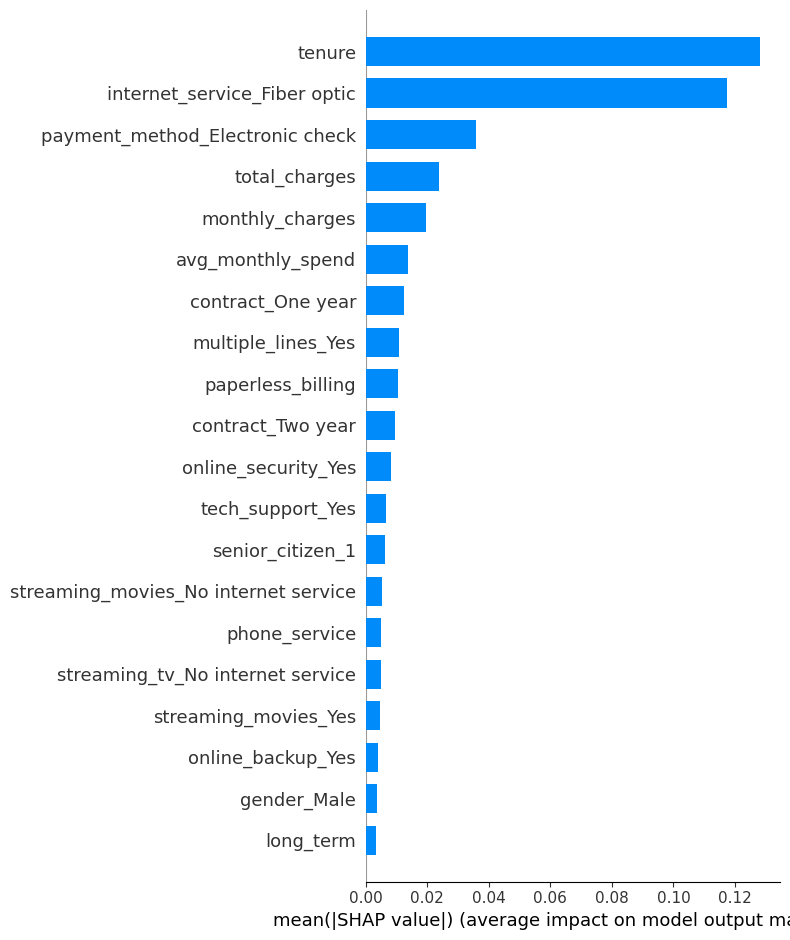

In [48]:
shap.summary_plot(shap_values, X_train, plot_type="bar")


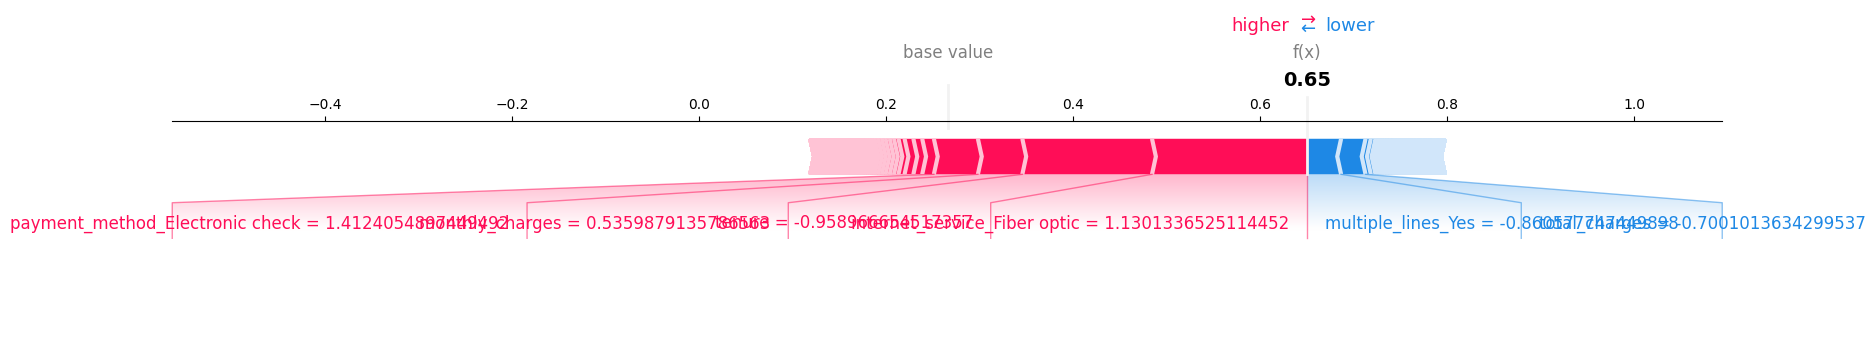

In [ ]:
## Force plot (Explain a single prediction)     
##  This gives a breakdown of how each feature pushed the prediction up/down

sample_index = 15
sample = X_test.iloc[sample_index:sample_index + 1]

shap_value = explainer.shap_values(sample)

shap.force_plot(explainer.expected_value, shap_value[0], sample, matplotlib = True)

In [ ]:
import joblib
import os
os.mkdir("models")
joblib.dump(rf_model, "models/rf_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")

# save column order (very important for user input mapping)
import json
with open("models/columns.json","w") as f:
    json.dump(list(X_train.columns), f)

##### Actually for better predictions we need more features and also test some more models to get the idea which is best 

In [ ]:
import pandas as pd
import numpy as np

# Safety copy
df = data.copy()

# -----------------------------------------
# Step 1: Handle basic nulls (optional early step)
df.replace(" ", np.nan, inplace=True)
df.dropna(inplace=True)  # or apply your imputation logic
# -----------------------------------------

# Step 2: Universal Feature Engineering (check column first)

# 1. Tenure bucket (categorize customer loyalty)
if 'tenure' in df.columns:
    def tenure_bucket(x):
        if x <= 12:
            return '0-1 yr'
        elif x <= 24:
            return '1-2 yrs'
        elif x <= 48:
            return '2-4 yrs'
        else:
            return '4+ yrs'
    df['tenure_group'] = df['tenure'].apply(tenure_bucket)

# 2. Number of subscribed services (if one-hot encoded)
service_keywords = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
service_yes_cols = [col for col in df.columns if col.endswith('_Yes') and any(k in col for k in service_keywords)]
if service_yes_cols:
    df['num_services'] = df[service_yes_cols].sum(axis=1)

# 3. Auto payment flag from one-hot encoded payment columns
auto_cols = [col for col in df.columns if 'automatic' in col.lower()]
if auto_cols:
    df['auto_payment'] = df[auto_cols].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

# 4. Charges ratio
if 'monthly_charges' in df.columns and 'total_charges' in df.columns:
    df['charges_ratio'] = df['monthly_charges'] / (df['total_charges'] + 1)

# 5. Interaction term: tenure × monthly_charges
if 'tenure' in df.columns and 'monthly_charges' in df.columns:
    df['tenure_monthly'] = df['tenure'] * df['monthly_charges']

# 6. Log transformation
if 'total_charges' in df.columns:
    df['log_total_charges'] = np.log1p(df['total_charges'])

# 7. Contract score (if available as raw string)
if 'contract' in df.columns:
    contract_map = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
    df['contract_score'] = df['contract'].map(contract_map)

# -----------------------------------------
# Step 3: Drop ID or leak-prone fields
drop_cols = [col for col in ['customer_id', 'user_id', 'transaction_id'] if col in df.columns]
df.drop(drop_cols, axis=1, inplace=True)
# -----------------------------------------

# Step 4: One-Hot Encoding
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# -----------------------------------------
# Final Output
print("✅ Final shape after feature engineering:", df.shape)
df.head()


✅ Final shape after feature engineering: (7032, 7072)


,partner,dependents,tenure,phone_service,paperless_billing,monthly_charges,total_charges,churn,avg_monthly_spend,long_term,...,payment_method_Electronic check,payment_method_Mailed check,num_services,auto_payment,charges_ratio,tenure_monthly,log_total_charges,tenure_group_1-2 yrs,tenure_group_2-4 yrs,tenure_group_4+ yrs
0,1,0,1,0,1,29.85,29.85,0,14.925000,0,...,1,0,1,0,0.967585,29.85,3.429137,False,False,False
1,0,0,34,1,0,56.95,1889.50,0,53.985714,1,...,0,1,2,0,0.030124,1936.30,7.544597,False,True,False
2,0,0,2,1,1,53.85,108.15,1,36.050000,0,...,0,1,2,0,0.493358,107.70,4.692723,False,False,False
3,0,0,45,0,0,42.30,1840.75,0,40.016304,1,...,0,0,3,0,0.022967,1903.50,7.518471,False,True,False
4,0,0,2,1,1,70.70,151.65,1,50.550000,0,...,1,0,0,0,0.463151,141.40,5.028148,False,False,False


In [54]:
X = df.drop('churn', axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


##### Training models

In [55]:
### Base line model

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

model = LogisticRegression(max_iter = 1000)
scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'accuracy')
print("Logistic regression CV accuracy:", scores.mean())

Logistic regression CV accuracy: 0.7950311609126145


In [56]:
###     Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state = 42)
scores = cross_val_score(rf, X_train, y_train, cv = 5, scoring = 'accuracy')
print("random forest CV accuracy: ", scores.mean())

###     XGBoost classifier
from xgboost import XGBClassifier
xgb = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss')
scores = cross_val_score(xgb, X_train, y_train, cv = 5, scoring = 'accuracy')
print("XGBoost CV Accuracy:", scores.mean())

###  LightGBM Classifier
from lightgbm import LGBMClassifier

lgb = LGBMClassifier()
scores = cross_val_score(lgb, X_train, y_train, cv=5, scoring='accuracy')
print("LightGBM CV Accuracy:", scores.mean())

###     MLP Classifier (Neural Network)
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
scores = cross_val_score(mlp, X_train, y_train, cv=5, scoring='accuracy')
print("MLP Classifier CV Accuracy:", scores.mean())


random forest CV accuracy:  0.7946518341322159
XGBoost CV Accuracy: 0.7802440713328597
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1121, number of negative: 3098
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1704
[LightGBM] [Info] Number of data points in the train set: 4219, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265703 -> initscore=-1.016536
[LightGBM] [Info] Start training from score -1.016536
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1121, number of negative: 3098
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wi

In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

f1 = make_scorer(f1_score)
scores = cross_val_score(xgb, X_train, y_train, cv = 5, scoring = f1)
print("XGBoost CV F! Score: ", scores.mean())

XGBoost CV F! Score:  0.5546553595993096


In [58]:
# Initialize empty list
model_results = []

# Function to evaluate and log
def log_model(name, model):
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import make_scorer, f1_score, accuracy_score
    
    acc = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    f1 = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(f1_score)).mean()
    
    model_results.append({
        "Model": name,
        "CV Accuracy": round(acc, 4),
        "CV F1 Score": round(f1, 4)
    })

# Add your models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

log_model("Logistic Regression", LogisticRegression(max_iter=1000))
log_model("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42))
log_model("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
log_model("LightGBM", LGBMClassifier())
log_model("MLP Classifier", MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42))

# Display results
results_df = pd.DataFrame(model_results)
results_df.sort_values(by="CV F1 Score", ascending=False)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1121, number of negative: 3098
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1704
[LightGBM] [Info] Number of data points in the train set: 4219, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265703 -> initscore=-1.016536
[LightGBM] [Info] Start training from score -1.016536
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1121, number of negative: 3098
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1704
[LightGBM] [Info] Nu

,Model,CV Accuracy,CV F1 Score
0,Logistic Regression,0.7950,0.6268
3,LightGBM,0.7873,0.5642
4,MLP Classifier,0.6428,0.5620
2,XGBoost,0.7802,0.5547
1,Random Forest,0.7947,0.5402


#####   So from above we can see that Logistic regession is outperforming other models 

Now how to know it's not an accident. You can check consistency across CV,

`
if(std < 0.02): 
    model is stable, & trustworthy
` 

In [61]:
from sklearn.model_selection import cross_val_score
import numpy as np

model = LogisticRegression(max_iter=1000)
acc = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')

print("Accuracies:", acc)
print("F1 scores :", f1)
print("Std dev Accuracy:", np.std(acc))
print("Std dev F1     :", np.std(f1))


Accuracies: [0.79810427 0.79241706 0.79905213 0.79620853 0.78937381]
F1 scores : [0.65024631 0.61780105 0.63321799 0.62081129 0.61188811]
Std dev Accuracy: 0.0036287042859245817
Std dev F1     : 0.01363913385839689


#####   Compare Overfitting (Train vs Test)
If test almost equals to train then it's good generalization

else {test > train} --> that there is some regularization or data quirks

In [62]:
model.fit(X_train, y_train)
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print("Train Accuracy : ", train_acc)
print("Test ACcuracy : ", test_acc)

Train Accuracy :  1.0
Test ACcuracy :  0.7935153583617748


#####   From the above we have Overfitting alert !!!

In [70]:
# String regularization (C<1)
model = LogisticRegression(C = 0.0001, max_iter= 1000)
model.fit(X_train, y_train)

print("Train Accuracy : ", model.score(X_train, y_train))
print("Test Accuracy : ", model.score(X_test, y_test))

Train Accuracy :  0.7421312097080015
Test Accuracy :  0.7343572241183163


##### SHAP Force plot (Sigle prediction explaination)
Explaines why this one customer was predicted to churn 

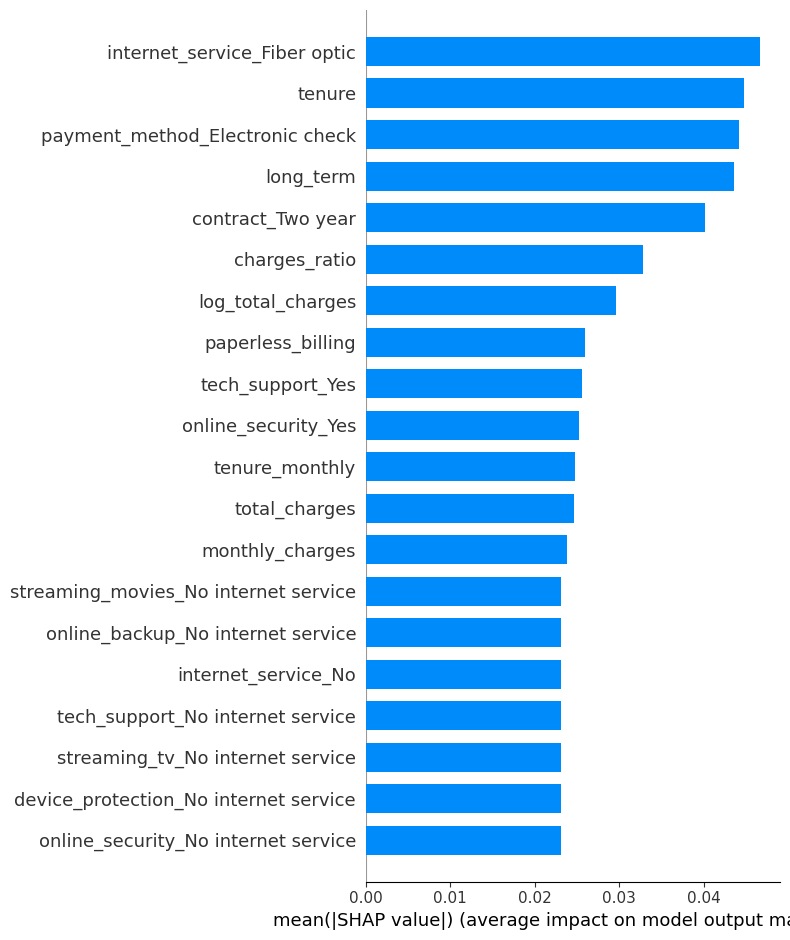

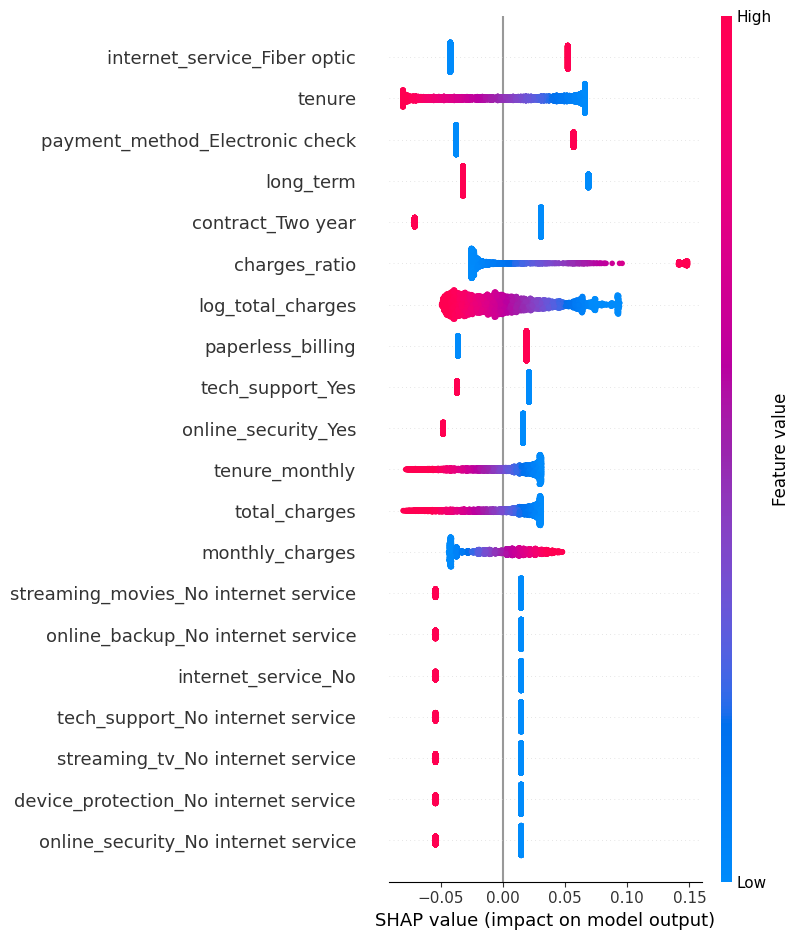

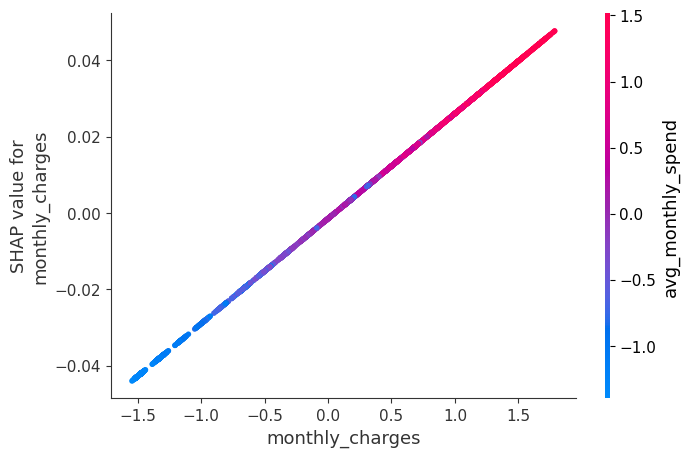

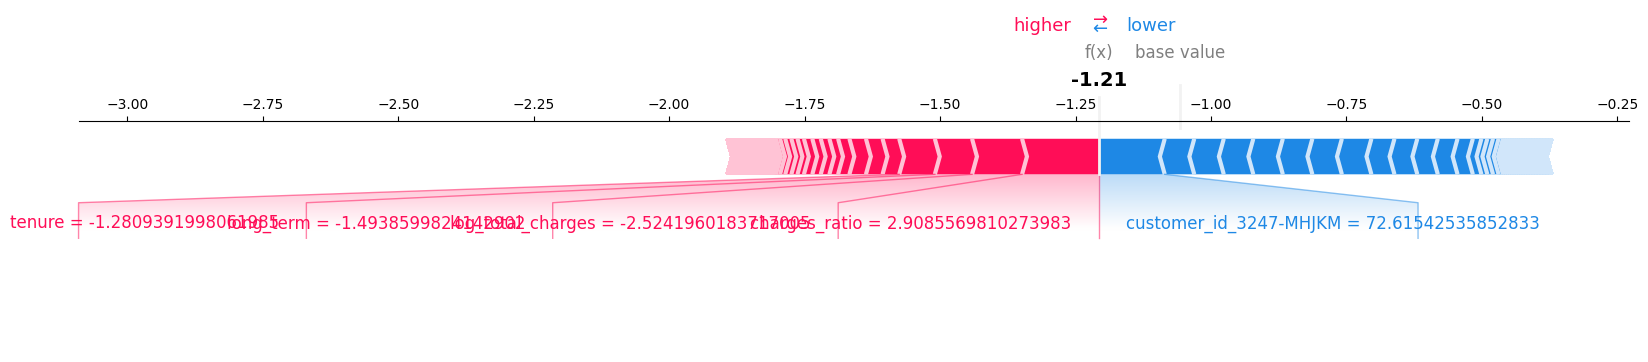

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make sure all columns in X_train are numeric and of correct type
X_train_clean = pd.DataFrame(X_train, columns=X_train.columns).astype(np.float64)

# Recreate the SHAP Explainer
masker = shap.maskers.Independent(data=X_train_clean)
explainer = shap.Explainer(model, masker)

# Get SHAP values properly as Explanation object
shap_values = explainer(X_train_clean)

#  Summary Bar Plot
shap.summary_plot(shap_values, X_train_clean, plot_type="bar")

#  Beeswarm Summary Plot
shap.summary_plot(shap_values, X_train_clean)

#  Dependence Plot
shap.dependence_plot("monthly_charges", shap_values.values, X_train_clean, feature_names=X_train_clean.columns)

#  Force Plot for individual prediction
shap.force_plot(explainer.expected_value, shap_values.values[5], X_train_clean.iloc[5], matplotlib=True)


##### Productionizing the model via Streamlit + GitHub + Deployment

In [84]:
import joblib
joblib.dump(model, "Logistic_model.pkl")        ###     save model
joblib.dump(scaler, "scaler.pkl")           ###     save scaler (used to scale user inputs)

joblib.dump(X_train.columns.tolist(), "feature_columns.pkl")        ###     save column names (used to align inputs)

['feature_columns.pkl']

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

acc   = accuracy_score(y_test, y_pred)
prec  = precision_score(y_test, y_pred)
rec   = recall_score(y_test, y_pred)
f1    = f1_score(y_test, y_pred)
cm    = confusion_matrix(y_test, y_pred)

print("▶️ Test set performance:")
print(f"Accuracy : {acc:.4f}")
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


▶️ Test set performance:
Accuracy : 0.7344
Confusion Matrix:
 [[1291    0]
 [ 467    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.73      1.00      0.85      1291
           1       0.00      0.00      0.00       467

    accuracy                           0.73      1758
   macro avg       0.37      0.50      0.42      1758
weighted avg       0.54      0.73      0.62      1758



e:\Data_Science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\Data_Science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\Data_Science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\Data_Science\.venv\Lib\site-packages\sklea

#####  Now we can also do some hyperparameter tuing for the models 

*   `RandomizedSearchCV` (faster than Grid)
*   `StratifiedKFold`  cross-validation (for class imbalance)
*   `F1`    as main metric (since churn is imbalanced)

##### Tuning Logistic Regression

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [200, 500]
}

log_reg = LogisticRegression(random_state=42)

grid_lr = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train, y_train)

print("Best Logistic Regression Parameters:", grid_lr.best_params_)
print("F1 Score (best):", grid_lr.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Logistic Regression Parameters: {'C': 10, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}
F1 Score (best): 0.6331198153814317


##### Tuning LightGBM 

In [91]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

lgbm = LGBMClassifier(random_state=42)

param_dist = {
    'num_leaves': randint(10, 150),
    'max_depth': randint(3, 20),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 1000),
    'min_child_samples': randint(10, 100),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
}

rand_lgbm = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    scoring='f1',
    n_iter=50,
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rand_lgbm.fit(X_train, y_train)

print("Best LightGBM Parameters:", rand_lgbm.best_params_)
print("F1 Score (best):", rand_lgbm.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1402, number of negative: 3872
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1704
[LightGBM] [Info] Number of data points in the train set: 5274, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265832 -> initscore=-1.015871
[LightGBM] [Info] Start training from score -1.015871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

##### Comparing them on TEST Set

In [92]:
from sklearn.metrics import classification_report

best_lr = grid_lr.best_estimator_
best_lgbm = rand_lgbm.best_estimator_

print("\n Logistic Regression on Test Set:")
y_pred_lr = best_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))

print("\n LightGBM on Test Set:")
y_pred_lgbm = best_lgbm.predict(X_test)
print(classification_report(y_test, y_pred_lgbm))



 Logistic Regression on Test Set:
              precision    recall  f1-score   support

           0       0.81      0.95      0.87      1291
           1       0.71      0.37      0.49       467

    accuracy                           0.79      1758
   macro avg       0.76      0.66      0.68      1758
weighted avg       0.78      0.79      0.77      1758


 LightGBM on Test Set:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1291
           1       0.64      0.52      0.58       467

    accuracy                           0.80      1758
   macro avg       0.74      0.71      0.72      1758
weighted avg       0.79      0.80      0.79      1758



In [93]:
joblib.dump(best_lr, "logistic_model_tuned.pkl")
joblib.dump(best_lgbm, "lgbm_model_tuned.pkl")


['lgbm_model_tuned.pkl']